In this notebook, the outputs generated for each scenario separately are combined for comparison of the scenarios. <br>
Plots are generated for visual comparison. Many different scenarios can be compared (i.e. more than 30).

In [118]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [119]:
output_path = '../output/'

In [120]:
# must be adjusted, if additional scenarios are used (compare with list in 00_launcher)
scenarios = ['base', 'ref_35', 'policy_35', 'ass',
             'tax_7', 'tax_8', 'tax_9', 'tax_10', 'tax_11', 'tax_12',
             'prk_1', 'prk_2', 'prk_4', 'lim', 
             'pt_1', 'pt_2-4', 'pt_5', 'pt_6', 'pt_7', 'pt_9',
             'inf_1', 'inf_2', 'inf_3_run-rail', 'inf_4', 'inf_5', 'inf_6',
             'reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5'
            ]

## Compare person kilometer shares by mode type between the scenarios

In [121]:
# define output excel file to be read for every scenario (every folder in 'output')
file_name = 'results_total.xlsx'
sheet_name = 'pkm_shares_total'
save_path = '../output/comparison/all_pkm_comp/'
unit = 'bn. pkm'
modes = ['air', 'bus', 'car', 'rail', 'walk', 'total']

# create a list with all paths to the files to be compared
file_list = []
for x in range(len(scenarios)):
    file_list.append(os.path.join(output_path, scenarios[x], file_name))

# read the data for every scenario and combine it in one list
excl_list = []
for x in range(len(file_list)):
    excl_list.append(pd.read_excel(file_list[x], sheet_name=sheet_name))
    
# convert the list to a pandas DataFrame for better handling
excl_merged = pd.DataFrame()
for excl_file in excl_list:
    excl_merged = pd.concat([excl_merged, excl_file], ignore_index=True)
excl_merged['mode']=excl_merged['Unnamed: 0']
excl_merged.drop(['Unnamed: 0'], axis=1, inplace=True)

# add the scenario name to the data in the pandas DataFrame
excl_merged['scenario'] = ""
for x in range(len(scenarios)):
    # add a row for 'air' if that row is missing (= no air travel)
    if excl_merged.at[x*6, 'mode'] != 'air':
        excl_merged.loc[x*6-0.5] = [0.0, 'air', np.nan]
        excl_merged = excl_merged.sort_index().reset_index(drop=True)
    # write the name in the scenario to all 
    for y in range(0, len(modes)):
        excl_merged.at[y+x*6, 'scenario'] = scenarios[x]
        
# define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df
excl_merged = swap_columns(excl_merged, unit, 'scenario')
print(excl_merged.tail(20))

    scenario   mode      bn. pkm
166    reg_2   walk    30.686253
167    reg_2  total  1223.264990
168    reg_3    air     0.000754
169    reg_3    bus    55.657001
170    reg_3    car  1017.848719
171    reg_3   rail    94.859399
172    reg_3   walk    30.606053
173    reg_3  total  1198.971930
174    reg_4    air     0.000491
175    reg_4    bus    47.331698
176    reg_4    car   812.234048
177    reg_4   rail    71.183623
178    reg_4   walk    25.255967
179    reg_4  total   956.005830
180    reg_5    air     0.000914
181    reg_5    bus    55.833909
182    reg_5    car  1033.567933
183    reg_5   rail    95.428412
184    reg_5   walk    30.782310
185    reg_5  total  1215.613480


In [123]:
# plot the data, for every mode type their own plot with values for all scenarios in it
def plot_pkm(excl_merged, diff_ref=False):
    for mode in modes:
        pkm_mode = excl_merged.drop(excl_merged[excl_merged['mode'] != mode].index)
        fig = plt.figure(figsize=(10,5))
        
        # create bar chart   
        if diff_ref:
            # exclude base scenario
            pkm_mode = pkm_mode[1:]
            ref_35_row = pkm_mode[pkm_mode['scenario'] == 'ref_35'].iloc[0]
            pkm_mode['pkm_diff'] = ((pkm_mode[unit] - ref_35_row[unit]) / ref_35_row[unit]) * 100
            plt.bar(pkm_mode['scenario'], pkm_mode['pkm_diff'], width =0.7)
            plt.ylabel(f'{mode} {sheet_name} (% {unit} difference to ref_35)')
        else:
            plt.bar(pkm_mode['scenario'], pkm_mode[unit], width =0.7)
            plt.ylabel(f'{mode} {sheet_name} ({unit})')
            
        plt.xticks(rotation=90)
        plt.xlabel('Scenario')
        
        if diff_ref:
            plt.savefig(save_path + mode + '_' + sheet_name + '_diff_ref_35.pdf', bbox_inches='tight')
        else:    
            plt.savefig(save_path + mode + '_' + sheet_name + '_absolute.pdf', bbox_inches='tight')
        plt.close(fig)


plot_pkm(excl_merged, diff_ref=False)
plot_pkm(excl_merged, diff_ref=True)

"""    
# Create a stacked bar plot with the differences to ref_35:
# Filter out the 'total' rows
df_filtered = excl_merged[excl_merged['mode'] != 'total']

# Calculate the difference in bn. pkm for each mode compared to 'ref_35'
ref_35_row = df_filtered[df_filtered['scenario'] == 'ref_35']
# TODO is not working yet
df_filtered['diff'] = df_filtered.groupby('mode')['bn. pkm'].apply(lambda x: ((x - ref_35_row['bn. pkm'].values) /
                                                                              ref_35_row['bn. pkm'].values) * 100)

# Pivot the DataFrame to have modes as columns and scenarios as index
df_pivot = df_filtered.pivot(index='scenario', columns='mode', values='diff')

# Reorder the columns
column_order = ['car', 'rail', 'bus', 'walk', 'air']
df_pivot = df_pivot[column_order]

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
df_pivot.plot(kind='bar', stacked=True, ax=ax)

ax.set_ylabel('Difference (%)')
ax.set_xlabel('Scenario')
ax.set_title('Difference in bn. pkm for each Mode compared to ref_35')

plt.legend(title='Mode')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(output_path + 'comparison/all_pkm_comp/pkm_mode_comp_percent.pdf')
plt.show()
"""

"    \n# Create a stacked bar plot with the differences to ref_35:\n# Filter out the 'total' rows\ndf_filtered = excl_merged[excl_merged['mode'] != 'total']\n\n# Calculate the difference in bn. pkm for each mode compared to 'ref_35'\nref_35_row = df_filtered[df_filtered['scenario'] == 'ref_35']\n# TODO is not working yet\ndf_filtered['diff'] = df_filtered.groupby('mode')['bn. pkm'].apply(lambda x: ((x - ref_35_row['bn. pkm'].values) /\n                                                                              ref_35_row['bn. pkm'].values) * 100)\n\n# Pivot the DataFrame to have modes as columns and scenarios as index\ndf_pivot = df_filtered.pivot(index='scenario', columns='mode', values='diff')\n\n# Reorder the columns\ncolumn_order = ['car', 'rail', 'bus', 'walk', 'air']\ndf_pivot = df_pivot[column_order]\n\n# Plot the stacked bar chart\nfig, ax = plt.subplots(figsize=(10, 6))\ndf_pivot.plot(kind='bar', stacked=True, ax=ax)\n\nax.set_ylabel('Difference (%)')\nax.set_xlabel('Scenari

## Analyse carownership outputs

In [159]:
output_path = '../car_ownership/co_results/'
save_path = '../output/comparison/car_ownership/'
sheet_name = 'results'
#unit = 'bn. pkm'
#modes = ['air', 'bus', 'car', 'rail', 'walk', 'total']

# create a list with all paths to the files to be compared
file_list = []
for x in range(len(scenarios)):
    file_name = f"{scenarios[x]}.xlsx"
    file_list.append(os.path.join(output_path, file_name))

# read the data for every scenario and combine it in one list
excl_list = []
for x in range(len(file_list)):
    excl_list.append(pd.read_excel(file_list[x], sheet_name=sheet_name))
    
# convert the list to a pandas DataFrame for better handling
excl_merged = pd.DataFrame()
for excl_file in excl_list:
    excl_merged = pd.concat([excl_merged, excl_file], ignore_index=True)

# add the scenario name to the data in the pandas DataFrame
excl_merged['scenario'] = ""
for x in range(len(scenarios)):
    # write the name of the scenario to every table
    for y in range(0, 26):
        excl_merged.at[y+x*25, 'scenario'] = scenarios[x]
        
# define function to swap columns
#def swap_columns(df, col1, col2):
#    col_list = list(df.columns)
#    x, y = col_list.index(col1), col_list.index(col2)
#    col_list[y], col_list[x] = col_list[x], col_list[y]
#    df = df[col_list]
#    return df
#excl_merged = swap_columns(excl_merged, unit, 'scenario')

In [160]:
# plot the data, for every urbanisation type with values for all scenarios in it
to_analyse = ["Cars per household modelled", "Car availability modelled"]
save_name = ["car_p_hh", "car_avail"]
excl_merged.fillna(value=0, inplace=True)

for idx, var in enumerate(to_analyse):
    df = excl_merged.loc[excl_merged['key'] == var]
    df = swap_columns(df, "key", "scenario")
    df = df.drop(columns = ["choice", "key"]).reset_index(drop=True)
    
    # plot absolute data in separate bar charts
    for urb in ["rural", "suburban", "urban"]:
        cars = df[['scenario', urb]]
        # create bar chart
        fig = plt.figure(figsize=(10,5))
        plt.bar(cars['scenario'], cars[urb], width =0.7)
        plt.xticks(rotation=90)
        plt.xlabel('Scenario')
        plt.ylabel(f'{var} {urb}')
        plt.savefig(save_path + save_name[idx] + "_" + urb + ".pdf", bbox_inches='tight')
        plt.close(fig)
        
    # Plot absolute values as stacked bar plot
    fig, ax = plt.subplots(figsize=(6, 10))

    #x = df['scenario'][::-1]
    y = df['scenario'][::-1]
    y_pos = range(len(y))
    y_rural = df['rural'][::-1]
    y_suburban = df['suburban'][::-1]
    y_urban = df['urban'][::-1]

    #calculate the positions of the bars
    #bar_width = 0.5 #then print below: height = bar_width
    
    ax.barh(y_pos, y_rural, label='Rural')
    ax.barh(y_pos, y_suburban, label='Suburban', left=y_rural)
    ax.barh(y_pos, y_urban, label='Urban', left=y_rural + y_suburban)

    ax.set_xlabel(f'{var}')
    ax.set_ylabel('Scenario')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y)
    ax.set_title(f'{var} in absolute values')
    
    # Display values on each bar
    for i, (rural, suburban, urban) in enumerate(zip(y_rural, y_suburban, y_urban)):
        ax.text(rural / 2, i, f'{rural:.2f}', ha='center', va='center')
        ax.text(rural + suburban / 2, i, f'{suburban:.2f}', ha='center', va='center')
        ax.text(rural + suburban + urban / 2, i, f'{urban:.2f}', ha='center', va='center')

    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.close()
    fig.savefig(save_path + save_name[idx] + "_absolute.pdf")
    
    #_____________________________________________________    
    # plot difference in percent compared to ref_35 in stacked bar plot
    ref_35_row = df[df['scenario'] == 'ref_35'].iloc[0]
    df['rural_diff'] = ((df['rural'] - ref_35_row['rural']) / ref_35_row['rural']) * 100
    df['suburban_diff'] = ((df['suburban'] - ref_35_row['suburban']) / ref_35_row['suburban']) * 100
    df['urban_diff'] = ((df['urban'] - ref_35_row['urban']) / ref_35_row['urban']) * 100

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    x = df['scenario'][1:]
    y_rural = df['rural_diff'][1:]
    y_suburban = df['suburban_diff'][1:]
    y_urban = df['urban_diff'][1:]

    ax.bar(x, y_rural, label='Rural')
    ax.bar(x, y_suburban, label='Suburban', bottom=y_rural)
    ax.bar(x, y_urban, label='Urban', bottom=y_rural + y_suburban)

    ax.set_ylabel('Difference (%)')
    ax.set_xlabel('Scenario')
    ax.set_title(f'Difference of {var} in % compared to ref_35')

    ax.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.close() # or use plt.show() to view plots in here
    fig.savefig(save_path + save_name[idx] + "_percent_change.pdf")

## Compare (local and long-distance) emissions for different scenarios

In [161]:
# still in work for combination of long-distance and short-distance emissions
# define output excel file to be read for every scenario (every folder in 'output')
output_path = '../output/'
save_path = '../output/comparison/emiss_comp/'
file_name = 'results_total.xlsx'
sheet_name__local = 'emissions_local'
sheet_name_long = 'emissions_long'
modes_local = ['bus', 'car', 'rail_short', 'walk']
modes_long = ['air', 'bus', 'coach', 'rail_long', 'rail_short', 'car_long']
unit = 'mio tCO2eq'

# create a list with all paths to the files to be compared
file_list = []
for x in range(len(scenarios)):
    file_list.append(os.path.join(output_path, scenarios[x], file_name))
    

"""LOCAL emissions"""
# read the data for every scenario and combine it in one list
excl_list_local = []
for x in range(len(file_list)):
    excl_list_local.append(pd.read_excel(file_list[x], sheet_name=sheet_name__local))
    
# convert the list to a pandas DataFrame for better handling
excl_merged_local = pd.DataFrame()
for excl_file in excl_list_local:
    excl_merged_local = pd.concat([excl_merged_local, excl_file], ignore_index=True)

excl_merged_local.rename({'route_type':'mode'}, axis=1, inplace=True)
to_replace = {'bus': 'bus_local', 'rail_short': 'rail_local', 'car': 'car_local'}
excl_merged_local['mode'].replace(to_replace, inplace=True)

# Add scenario names to pandas dataframes
excl_merged_local['scenario'] = ""
for x in range(len(scenarios)):
    # write the name in the scenario to all respective modes
    for y in range(0, len(modes_local)):
        excl_merged_local.at[y+x*len(modes_local), 'scenario'] = scenarios[x]
        
    
"""LONG distance emissions"""
# Read in the data for every scenario as list
excl_list_long = []
for x in range(len(file_list)):
    excl_list_long.append(pd.read_excel(file_list[x], sheet_name=sheet_name_long))

# Convert the list to a pandas DataFrame for better handling
excl_merged_long = pd.DataFrame()
for excl_file in excl_list_long:
    excl_merged_long = pd.concat([excl_merged_long, excl_file], ignore_index=True)
    
excl_merged_long.rename({'Unnamed: 0':'mode'}, axis=1, inplace=True)
excl_merged_long['mode'].replace({'bus': 'bus_long'}, inplace=True)

excl_merged_long['scenario'] = ""
for x in range(len(scenarios)):
    
    # add a row for 'air' if that row is missing (= no air travel)
    if excl_merged_long.at[x*len(modes_long), 'mode'] != 'air':
        excl_merged_long.loc[x*len(modes_long)-0.5] = [0.0, 'air', np.nan]
        excl_merged_long = excl_merged_long.sort_index().reset_index(drop=True)
    
    # write the name in the scenario to all respective modes
    for y in range(0, len(modes_long)):
        excl_merged_long.at[y+x*len(modes_long), 'scenario'] = scenarios[x]

excl_merged = pd.concat([excl_merged_local, excl_merged_long], ignore_index=True)
excl_merged = swap_columns(excl_merged, unit, 'scenario')
excl_merged = swap_columns(excl_merged, 'mode', 'scenario')
print(excl_merged.head(20))

     scenario        mode mio tCO2eq
0        base   bus_local   2.065105
1        base   car_local  31.925916
2        base  rail_local   0.667623
3        base        walk        0.0
4      ref_35   bus_local   2.240015
5      ref_35   car_local  16.457341
6      ref_35  rail_local   0.415433
7      ref_35        walk        0.0
8   policy_35   bus_local   1.992583
9   policy_35   car_local  13.725144
10  policy_35  rail_local   0.333939
11  policy_35        walk        0.0
12        ass   bus_local   2.239652
13        ass   car_local  16.455336
14        ass  rail_local   0.415333
15        ass        walk        0.0
16      tax_7   bus_local   2.239401
17      tax_7   car_local  16.451773
18      tax_7  rail_local   0.415366
19      tax_7        walk        0.0


In [162]:
modes = ['bus_local', 'car_local', 'rail_local',
         'air', 'bus_long', 'coach', 'rail_short', 'rail_long', 'car_long'] # walk left out
excl_merged.fillna(value=0, inplace=True)
for idx, mode in enumerate(modes):
    df = excl_merged.loc[excl_merged['mode'] == mode]
    df = df.drop(columns = ["mode"]).reset_index(drop=True)
    
    # plot absolute data in separate bar charts
    # create bar chart
    fig = plt.figure(figsize=(10,5))
    plt.bar(df['scenario'], df[unit], width =0.7)
    plt.xticks(rotation=90)
    plt.xlabel('Scenario')
    plt.ylabel(f'Emissions of {mode} ({unit})')
    plt.savefig(save_path + "emiss_" f"{mode}_absolute.pdf", bbox_inches='tight')
    plt.close(fig)

""" 
    #_____________________________________________________    
    # plot difference in percent compared to ref_35 in stacked bar plot
    ref_35_row = df[df['scenario'] == 'ref_35'].iloc[0]
    df['rural_diff'] = ((df['rural'] - ref_35_row['rural']) / ref_35_row['rural']) * 100
    df['suburban_diff'] = ((df['suburban'] - ref_35_row['suburban']) / ref_35_row['suburban']) * 100
    df['urban_diff'] = ((df['urban'] - ref_35_row['urban']) / ref_35_row['urban']) * 100

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    x = df['scenario'][1:]
    y_rural = df['rural_diff'][1:]
    y_suburban = df['suburban_diff'][1:]
    y_urban = df['urban_diff'][1:]

    ax.bar(x, y_rural, label='Rural')
    ax.bar(x, y_suburban, label='Suburban', bottom=y_rural)
    ax.bar(x, y_urban, label='Urban', bottom=y_rural + y_suburban)

    ax.set_ylabel('Difference (%)')
    ax.set_xlabel('Scenario')
    ax.set_title(f'Difference of {var} in % compared to ref_35')

    ax.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.close() # or use plt.show() to view plots in here
    fig.savefig(save_path + save_name[idx] + "_percent_change.pdf")
"""

' \n    #_____________________________________________________    \n    # plot difference in percent compared to ref_35 in stacked bar plot\n    ref_35_row = df[df[\'scenario\'] == \'ref_35\'].iloc[0]\n    df[\'rural_diff\'] = ((df[\'rural\'] - ref_35_row[\'rural\']) / ref_35_row[\'rural\']) * 100\n    df[\'suburban_diff\'] = ((df[\'suburban\'] - ref_35_row[\'suburban\']) / ref_35_row[\'suburban\']) * 100\n    df[\'urban_diff\'] = ((df[\'urban\'] - ref_35_row[\'urban\']) / ref_35_row[\'urban\']) * 100\n\n    # Plot the bar chart\n    fig, ax = plt.subplots(figsize=(10, 6))\n\n    x = df[\'scenario\'][1:]\n    y_rural = df[\'rural_diff\'][1:]\n    y_suburban = df[\'suburban_diff\'][1:]\n    y_urban = df[\'urban_diff\'][1:]\n\n    ax.bar(x, y_rural, label=\'Rural\')\n    ax.bar(x, y_suburban, label=\'Suburban\', bottom=y_rural)\n    ax.bar(x, y_urban, label=\'Urban\', bottom=y_rural + y_suburban)\n\n    ax.set_ylabel(\'Difference (%)\')\n    ax.set_xlabel(\'Scenario\')\n    ax.set_title(

mode             car_long  car_local    bus_long  bus_local  rail_short  \
scenario                                                                  
ref_35           0.000000   0.000000    0.000000   0.000000    0.000000   
policy_35      -38.986317 -16.601688  127.700703 -11.045987   13.788108   
ass             -0.000470  -0.012182    0.024971  -0.016197    0.155446   
tax_7           -0.051821  -0.033832    0.191920  -0.027392    0.069318   
tax_8           -0.432288  -0.221050    0.887095  -0.045524    0.909650   
tax_9           -0.176989  -0.073978    0.427995  -0.055001    0.485931   
tax_10          -0.059028  -0.058563    0.059660   0.000810    0.212199   
tax_11          -0.071122  -0.038398    0.159617   0.024534    0.057232   
tax_12          -1.027805  -0.438948    2.292099  -0.144908    2.003357   
prk_1           -4.878329   1.444599    4.565698   3.791864    5.803684   
prk_2           -2.296323  -0.212062   10.755655  -2.476294   15.936787   
prk_4           -0.566964

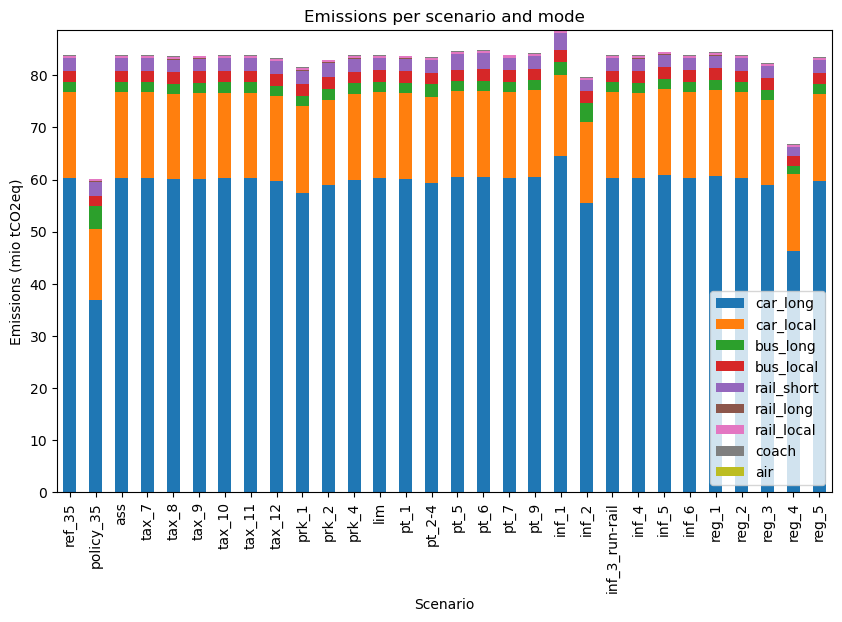

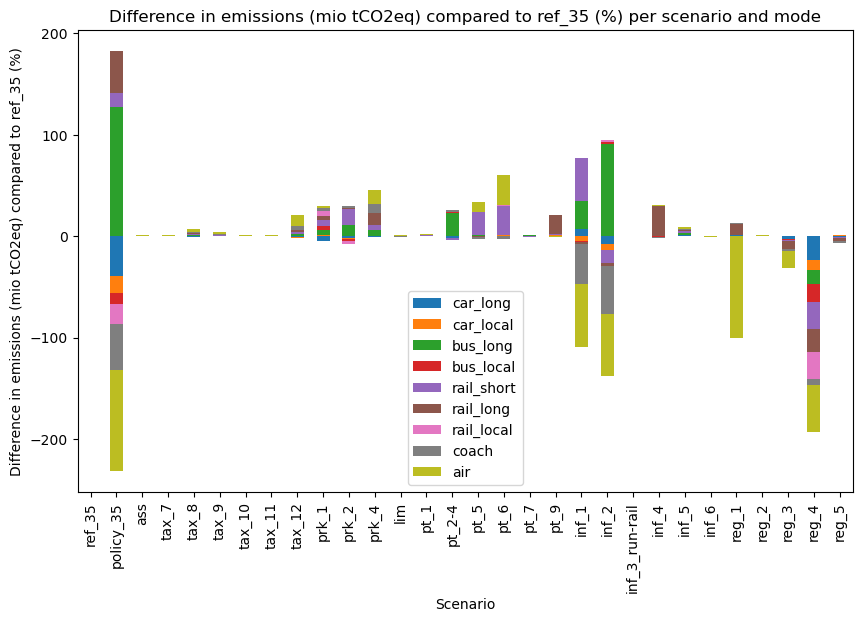

In [163]:
# plot stacked bar plots
# Define the order of modes
mode_order = ['car_long', 'car_local', 'bus_long', 'bus_local', 'rail_short',   
              'rail_long', 'rail_local', 'coach', 'air'] # walk left out

# Pivot the dataframe to convert modes into columns
pivoted_df = excl_merged.pivot(index='scenario', columns='mode', values='mio tCO2eq')
pivoted_df.fillna(value=0, inplace=True)

# Reorder the columns based on mode_order
pivoted_df = pivoted_df[mode_order]
pivoted_df = pivoted_df.reindex(scenarios)
pivoted_df.drop(labels='base', axis='index', inplace=True)

# Plot ABSOLUTE values as stacked bar plot
pivoted_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Scenario')
plt.ylabel('Emissions (mio tCO2eq)')
plt.title('Emissions per scenario and mode')
plt.legend(loc='lower right')
plt.close(fig)
plt.savefig(save_path + "emiss_stacked_absolute.pdf", bbox_inches='tight')

# Plot DIFFERENCE to ref_35 as stacked bar plot
df_diff = (pivoted_df.subtract(pivoted_df.loc['ref_35']) / pivoted_df.loc['ref_35']) * 100
print(df_diff)
df_diff.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Scenario')
plt.ylabel('Difference in emissions (mio tCO2eq) compared to ref_35 (%)')
plt.title('Difference in emissions (mio tCO2eq) compared to ref_35 (%) per scenario and mode')
plt.legend(loc='lower center')
plt.close(fig)
plt.savefig(save_path + "emiss_stacked_diff_ref_35.pdf", bbox_inches='tight')